# Predict House Price 

Goal is to create a machine pipeline that can accurately predict the sales price for each house.

Data is from https://www.kaggle.com/c/house-prices-advanced-regression-techniques

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
from platform import python_version
print(python_version())

3.7.11


In [4]:
df = pd.read_csv('train.csv')

In [5]:
df.head(4)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000


This dataset contains 1460 observations with 79 features. 

In [6]:
df.shape

(1460, 81)

We will do following operations:
- Check for missing values and discard columns that contain too much missing information
- Impute missing values in numerical column by using iterative imputer
- Convert categorical columns with onehot encoder
- Create pipeline to apply imputing, standard scaling and machine learning models
- Test with PCA and without PCA
- Choose best parameters for machine learning models
- Finally apply on the test dataset provided by kaggle for submission

# Data Inspection and Preparation

In [7]:
# print percentage of missing values in each column/feature
def print_null_percentage(df):
    m=df.isnull().sum()
    null_columns=[]
    print('Feature Name | Num Missing Value | Total Num Value | Percentage')
    print('================================================================')
    for i,v in enumerate(m):
        if v!=0:
            print("%s %d  %d, P: %0.2f"%(m.index[i],v,df.shape[0],100*v/df.shape[0]))
            null_columns.append(m.index[i])
    return null_columns

In [8]:
null_columns=print_null_percentage(df)

Feature Name | Num Missing Value | Total Num Value | Percentage
LotFrontage 259  1460, P: 17.74
Alley 1369  1460, P: 93.77
MasVnrType 8  1460, P: 0.55
MasVnrArea 8  1460, P: 0.55
BsmtQual 37  1460, P: 2.53
BsmtCond 37  1460, P: 2.53
BsmtExposure 38  1460, P: 2.60
BsmtFinType1 37  1460, P: 2.53
BsmtFinType2 38  1460, P: 2.60
Electrical 1  1460, P: 0.07
FireplaceQu 690  1460, P: 47.26
GarageType 81  1460, P: 5.55
GarageYrBlt 81  1460, P: 5.55
GarageFinish 81  1460, P: 5.55
GarageQual 81  1460, P: 5.55
GarageCond 81  1460, P: 5.55
PoolQC 1453  1460, P: 99.52
Fence 1179  1460, P: 80.75
MiscFeature 1406  1460, P: 96.30


In [9]:
#Drop columns with too many missing values
drop_cols = ['Alley','MiscFeature','PoolQC','Fence','MiscFeature']
df.drop(columns=drop_cols,axis=1,inplace=True)

In [10]:
# Import Relevant Libraries

In [11]:
#Use multivariate imputer to impute values for 2 columns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import BayesianRidge
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.decomposition import PCA, KernelPCA, SparsePCA
from sklearn.feature_selection import SelectKBest, chi2
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [12]:
# Log Root Mean Square Error function to quantify the success of predictor 
def logrmse(y_true, y_pred):
    return np.sqrt(np.mean((np.log(y_true)-np.log(y_pred))**2))

## Preprocessing

We will use a Bayesian method for imputing missing values in numerical columns. 

Missing values in categorical column will be signed as None and regarded as a new category.

In [13]:
# Find categorical and numerical features for preprocessing steps. 
categorical = [c for c in df.columns if df[c].dtype=='object']
numerical = list(set(df.columns).difference(set(categorical+['Id','SalePrice'])))

In [14]:
print('There are {} categorical and {} numerical features'.format(len(categorical), len(numerical)))

There are 39 categorical and 36 numerical features


In [15]:
# Preprocessing steps
# Impute missing values
iter_imp = IterativeImputer(estimator=BayesianRidge(),
                         missing_values=np.nan, 
                         sample_posterior=True, 
                         max_iter=100, 
                         min_value=0, 
                         random_state=1)
# impute missing numerical values by using Bayesian Ridge
numerical_transformer = Pipeline(steps = [('imputer',iter_imp),
                                          ('scaler',StandardScaler())])
# fill missing values as 'None' so that they will be a new category
categorical_transformer = Pipeline(steps = [('imputer',SimpleImputer(strategy='constant',fill_value='None')),
                                            ('ohe', OneHotEncoder(sparse=False,handle_unknown='ignore'))])
ordinal_transformer = Pipeline(steps = [('imputer',SimpleImputer(strategy='constant')),
                                        ('ohe', OrdinalEncoder())])
preprocessor = ColumnTransformer(transformers = [('num',numerical_transformer,numerical),
                                                 ('cat',categorical_transformer,categorical)])

In [16]:
# Split dataset into training and test sets

In [17]:
X_train,X_test,y_train,y_test = train_test_split(df.iloc[:,1:-1],
                                                 df.iloc[:,-1],
                                                 test_size=0.33,
                                                 random_state=1)

# Machine Learning Models

## 1. Linear Regression with L1 Regularization (Lasso)

In [18]:
# Compare Lasso with and without PCA

### 1a. Lasso with PCA 

In [19]:
pipe_lr_wpca = Pipeline(steps=[('preprocessor', preprocessor),
                      ('reduce',PCA(n_components=10)),
                      ('classifier', Lasso(alpha=1.0))])

In [20]:
# Find the best alpha that gives the maximum validation score
alpha = np.logspace(0, 3, num=20, endpoint=True, base=10.0)
param_grid=[{
    'classifier__alpha': alpha
}]

In [21]:
gs_lr_wpca = GridSearchCV(pipe_lr_wpca,n_jobs=4, param_grid=param_grid)

In [22]:
gs_lr_wpca.fit(X_train, y_train);

In [23]:
gs_lr_report = pd.DataFrame(gs_lr_wpca.cv_results_)

Text(0.5, 1.0, 'Mean test score with PCA')

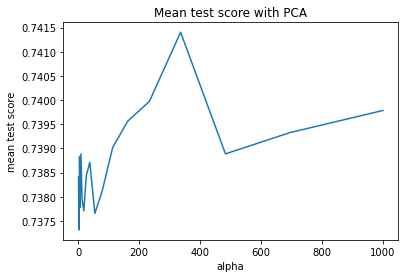

In [24]:
plt.plot(gs_lr_report['param_classifier__alpha'],gs_lr_report['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('mean test score')
plt.title('Mean test score with PCA')

### 1b. Lasso without PCA

In [25]:
pipe_lr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', Lasso(alpha=1.0))])

# Find the best alpha that gives the maximum test score

alpha = np.logspace(0, 3, num=20, endpoint=True, base=10.0)
param_grid=[{
    'classifier__alpha': alpha
}]

gs_lr_wop = GridSearchCV(pipe_lr,n_jobs=4, param_grid=param_grid)

gs_lr_wop.fit(X_train, y_train);

Text(0.5, 1.0, 'Mean test score without PCA')

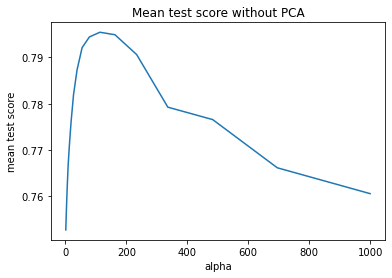

In [26]:
gs_lr_wop_report = pd.DataFrame(gs_lr_wop.cv_results_)
plt.plot(gs_lr_wop_report['param_classifier__alpha'],gs_lr_wop_report['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('mean test score')
plt.title('Mean test score without PCA')

In [27]:
print("Lasso with pca, Training score: %.3f" % gs_lr_wpca.score(X_train, y_train))
print("Lasso with pca, Test score: %.3f" % gs_lr_wpca.score(X_test, y_test))
print("Lasso without pca, Training score: %.3f" % gs_lr_wop.score(X_train, y_train))
print("Lasso without pca, Test score: %.3f" % gs_lr_wop.score(X_test, y_test))
print('---------------------------')
print("Lasso with pca, Training RMSE: %.3f" % logrmse(gs_lr_wpca.predict(X_train), y_train.values))
print("Lasso with pca, Test RMSE: %.3f" % logrmse(gs_lr_wpca.predict(X_test), y_test))
print("Lasso without pca, Training RMSE: %.3f" % logrmse(gs_lr_wop.predict(X_train), y_train))
print("Lasso without pca, Test RMSE: %.3f" % logrmse(gs_lr_wop.predict(X_train), y_train))

Lasso with pca, Training score: 0.763
Lasso with pca, Test score: 0.818
Lasso without pca, Training score: 0.923
Lasso without pca, Test score: 0.888
---------------------------


/home/esin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


Lasso with pca, Training RMSE: nan
Lasso with pca, Test RMSE: 0.199
Lasso without pca, Training RMSE: 0.108
Lasso without pca, Test RMSE: 0.106


Lasso performs quite well without PCA.

## Random Forest Regressor

In [28]:
# Test with Random Forest Regressor with different PCA types

In [33]:
pipe_rf = Pipeline(steps=[('preprocessor', preprocessor),
                         ('reduce_dim',PCA()),
                         ('classifier', RandomForestRegressor(n_estimators=500,
                                                           random_state=42))])

Compare different PCA algorithms and number of components

In [34]:
n_components = [1, 5, 10, 50]
n_estimators_rf = [100,500,1000]
param_grid = [
    {
        'reduce_dim':[PCA(),KernelPCA()],
        'reduce_dim__n_components' : n_components,
        'classifier__n_estimators': n_estimators_rf
    }
]


In [36]:
gs_rf = GridSearchCV(pipe_rf,n_jobs=4,param_grid=param_grid)

In [37]:
gs_rf.fit(X_train,y_train);

In [38]:
gs_rf_report=pd.DataFrame(gs_rf.cv_results_)

In [39]:
gs_rf_report.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__n_estimators,param_reduce_dim,param_reduce_dim__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,51.652182,1.662478,1.412773,0.097149,100,PCA(n_components=10),1,"{'classifier__n_estimators': 100, 'reduce_dim'...",0.703160,0.757407,0.715395,0.835991,0.824361,0.767263,0.054553,20
1,54.298085,1.279450,1.446241,0.095829,100,PCA(n_components=10),5,"{'classifier__n_estimators': 100, 'reduce_dim'...",0.827896,0.832613,0.787731,0.900994,0.899477,0.849742,0.044082,5
2,54.539925,1.098607,1.434471,0.094646,100,PCA(n_components=10),10,"{'classifier__n_estimators': 100, 'reduce_dim'...",0.824391,0.846983,0.779830,0.900517,0.907530,0.851850,0.047819,1
3,56.425828,1.542438,1.458856,0.151594,100,PCA(n_components=10),50,"{'classifier__n_estimators': 100, 'reduce_dim'...",0.791333,0.838095,0.757142,0.904165,0.910181,0.840183,0.060465,13
4,53.742189,0.934195,1.496450,0.118155,100,KernelPCA(),1,"{'classifier__n_estimators': 100, 'reduce_dim'...",0.703139,0.757407,0.715640,0.835991,0.824361,0.767307,0.054512,19


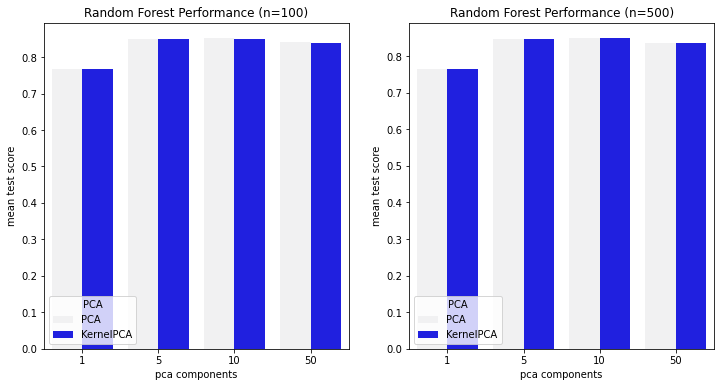

In [40]:
fig,[ax1,ax2]=plt.subplots(1,2,figsize=(12,6))
sns.barplot(data=gs_rf_report[gs_rf_report['param_classifier__n_estimators']==100],
            x="param_reduce_dim__n_components", 
            y="mean_test_score", 
            hue="param_reduce_dim", 
            color="b",
            ax=ax1)
ax1.set(ylabel='mean test score', xlabel='pca components', title='Random Forest Performance (n=100)')
handles, labels=ax1.get_legend_handles_labels()
ax1.legend(handles, ['PCA','KernelPCA'],title='PCA', loc='lower left');

sns.barplot(data=gs_rf_report[gs_rf_report['param_classifier__n_estimators']==500],
            x="param_reduce_dim__n_components", 
            y="mean_test_score", 
            hue="param_reduce_dim", 
            color="b",
            ax=ax2)
ax2.set(ylabel='mean test score', xlabel='pca components', title='Random Forest Performance (n=500)')
handles, labels=ax1.get_legend_handles_labels()
ax2.legend(handles, ['PCA','KernelPCA'],title='PCA', loc='lower left');


In [41]:
print("Random Forest Regression, Training score: %.3f" %gs_rf.score(X_train, y_train))
print("Random Forest Regression, Test score: %.3f" % gs_rf.score(X_test, y_test))
print('---------------------------')
print("Random Forest Regression, Training RMSE: %.3f" % logrmse(gs_rf.predict(X_train), y_train))
print("Random Forest Regression, Test RMSE: %.3f" % logrmse(gs_rf.predict(X_test), y_test))


Random Forest Regression, Training score: 0.966
Random Forest Regression, Test score: 0.862
---------------------------
Random Forest Regression, Training RMSE: 0.075
Random Forest Regression, Test RMSE: 0.162


## Gradient Boosting Regression

In [42]:
# Ensemble of weak classifiers

In [43]:
from sklearn.inspection import permutation_importance
#feature_importances_
from sklearn.ensemble import GradientBoostingRegressor

In [44]:
pipe_boost = Pipeline(steps=[('preprocessor',preprocessor),
              ('classifier', GradientBoostingRegressor(loss='lad',min_samples_split=5))])


We will find the effect of learning rate and maximum depth of weak classifiers on the Gradient Boosting Regression performance

In [45]:
n_estimators_gb = [500,1000, 1200]
lr = [0.1, 0.05, 0.01, 0.001]
max_depth = [3,4,5]
param_grid = [
    {
        'classifier__learning_rate' : lr,
        'classifier__n_estimators': n_estimators_gb,
        'classifier__max_depth': max_depth
    }
]


In [46]:
gs_gb = GridSearchCV(pipe_boost,n_jobs=3, param_grid=param_grid)

In [47]:
gs_gb.fit(X_train,y_train);

In [48]:
gs_gb_report=pd.DataFrame(gs_gb.cv_results_)

In [49]:
gs_gb_report.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__learning_rate,param_classifier__max_depth,param_classifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,45.829974,8.109150,0.999174,0.234132,0.1,3,500,"{'classifier__learning_rate': 0.1, 'classifier...",0.847526,0.845442,0.769678,0.864916,0.903577,0.846228,0.043590,19
1,53.136551,8.436962,1.201640,0.373167,0.1,3,1000,"{'classifier__learning_rate': 0.1, 'classifier...",0.830612,0.869893,0.783594,0.867740,0.910808,0.852529,0.042806,10
2,52.428347,10.070871,0.966829,0.184031,0.1,3,1200,"{'classifier__learning_rate': 0.1, 'classifier...",0.842007,0.842248,0.810565,0.851997,0.909455,0.851255,0.032281,15
3,48.648168,8.558362,1.316960,0.121633,0.1,4,500,"{'classifier__learning_rate': 0.1, 'classifier...",0.815260,0.863391,0.762700,0.884175,0.911568,0.847419,0.052787,17
4,55.778568,8.766752,1.110395,0.270809,0.1,4,1000,"{'classifier__learning_rate': 0.1, 'classifier...",0.822805,0.877851,0.787018,0.871793,0.898453,0.851584,0.040724,13


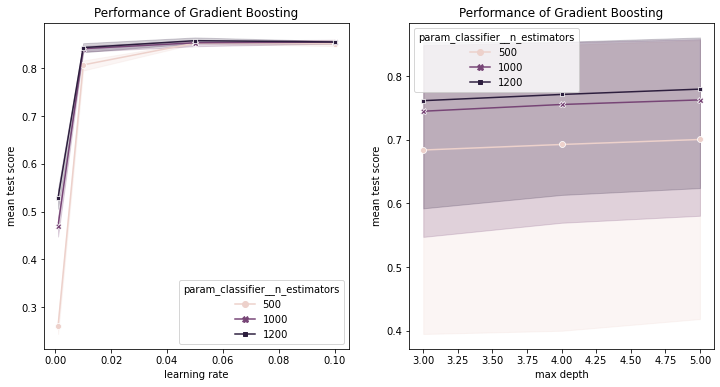

In [50]:
fig,[ax1,ax2]=plt.subplots(1,2,figsize=(12,6))
sns.lineplot(data=gs_gb_report, 
             x='param_classifier__learning_rate',
             y='mean_test_score',
             hue='param_classifier__n_estimators',
             style="param_classifier__n_estimators",
             ax=ax1, markers=True, dashes=False,
             )
ax1.set(xlabel='learning rate',ylabel='mean test score', title='Performance of Gradient Boosting')
sns.lineplot(data=gs_gb_report,
             x='param_classifier__max_depth',
             y='mean_test_score',
             hue='param_classifier__n_estimators',
             style="param_classifier__n_estimators",
             ax=ax2, markers=True, dashes=False)
ax2.set(xlabel='max depth',ylabel='mean test score', title='Performance of Gradient Boosting');


Gradient Boosting is robust for different parameter setting.

In [51]:
gs_gb.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   IterativeImputer(estimator=BayesianRidge(),
                                                                                    max_iter=100,
                                                                                    min_value=0,
                                                                                    random_state=1,
                                                                                    sample_posterior=True)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['YrSold', 'BsmtUnfSF',
                                                   'GrLivArea', 'MiscVal',
   

In [52]:
print("Gradient Boosting Regression, Training score: %.3f" %gs_gb.score(X_train, y_train))
print("Gradient Boosting Regression, Test score: %.3f" % gs_gb.score(X_test, y_test))
print('---------------------------')
print("Gradient Boosting Regression Training RMSE: %.3f" % logrmse(gs_gb.predict(X_train), y_train.values))
print("Gradient Boosting Regression, Test RMSE: %.3f" % logrmse(gs_gb.predict(X_test), y_test))


Gradient Boosting Regression, Training score: 0.983
Gradient Boosting Regression, Test score: 0.897
---------------------------
Gradient Boosting Regression Training RMSE: 0.051
Gradient Boosting Regression, Test RMSE: 0.147


## XGBOOST

XGBOOST is an efficient implementation of Gradient Boosting of decision trees

In [53]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

In [54]:
# Find best hyperparameter set
eta = np.arange(0.01,0.21,0.01).tolist()
min_child_weight = np.arange(1,11).tolist()
max_depth  = np.arange(2,11).tolist()
gamma = np.arange(2,11).tolist()
lambdaa = np.arange(2,11).tolist()
alpha = np.arange(2,11).tolist()
colsample_bytree = np.arange(0.4,1.1,0.1).tolist()

parameters = {'booster': ['gbtree'],
              'eta': eta, 
              'min_child_weight': min_child_weight,
              'max_depth': max_depth, 
              'gamma': gamma,  
              'colsample_bytree': colsample_bytree
             }

model = xgb.XGBRegressor()
gs_xg= RandomizedSearchCV(model,parameters, n_iter = 30)


In [63]:
X_train_pr = preprocessor.fit_transform(X_train)

In [57]:
gs_xg.fit(X_train_pr, y_train)

RandomizedSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs...
                                        'colsample_bytree': [0.4, 0.5, 0.6, 0.7,
                                                             0.7999999999999999,
                                                

In [65]:
X_test_pr = preprocessor.transform(X_test)

In [67]:
#Predicting and accuracy results
print("Parameters of the best model:")
print(gs_xg.best_params_)
print("XGBOOST Train accuracy: %.2f " % (gs_xg.score(X_train_pr,y_train)))
print("XGBOOST Test accuracy: %.2f " % (gs_xg.score(X_test_pr,y_test)))
print('---------------------------')
print("XGBOOST Train RMSE: %.2f " % logrmse(gs_xg.predict(X_train_pr),y_train))
print("XGBOOST Test RMSE: %.2f " % logrmse(gs_xg.predict(X_test_pr),y_test))


Parameters of the best model:
{'min_child_weight': 9, 'max_depth': 5, 'gamma': 3, 'eta': 0.17, 'colsample_bytree': 0.7999999999999999, 'booster': 'gbtree'}
XGBOOST Train accuracy: 0.99 
XGBOOST Test accuracy: 0.89 
---------------------------
XGBOOST Train RMSE: 0.05 
XGBOOST Test RMSE: 0.15 


# Summary

In [68]:
# Accuracy and RMSE comparison of different methods
acc,err = [],[]
for m in [gs_lr_wpca,gs_lr_wop,gs_rf,gs_gb,gs_xg]:
    if m == gs_xg:
        acc.append(m.score(X_test_pr,y_test))
        err.append(logrmse(m.predict(X_test_pr),y_test))
    else:
        acc.append(m.score(X_test,y_test))
        err.append(logrmse(m.predict(X_test),y_test))

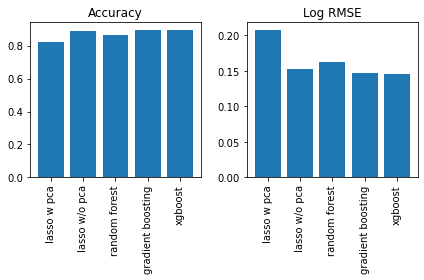

In [80]:
modelnames=['lasso w pca','lasso w/o pca','random forest','gradient boosting', 'xgboost']
fig,(ax1,ax2) = plt.subplots(1,2)
ax1.bar(np.arange(len(modelnames)),acc)
ax1.set_title('Accuracy')
ax2.bar(np.arange(len(modelnames)),err)
ax2.set_title('Log RMSE')
ax1.set_xticks(range(len(modelnames)))
ax2.set_xticks(range(len(modelnames)))
ax1.set_xticklabels(modelnames,rotation=90)
ax2.set_xticklabels(modelnames,rotation=90)
fig.tight_layout()

In [85]:
print('Best model in terms of smallest log RMSE is ',modelnames[np.argmin(err)])

Best model in terms of smallest log RMSE is  xgboost


In [86]:
print('Best model in terms of highest accuracy is ',modelnames[np.argmax(acc)])

Best model in terms of highest accuracy is  gradient boosting


## Test on Submission Dataset

In [87]:
df_sub = pd.read_csv('test.csv')

In [90]:
# Remove columns that were mostly empty in training set
df_sub.drop(columns=drop_cols,axis=1,inplace=True)

In [91]:
X_final_test = df_sub.iloc[:,1:]

In [92]:
X_final_test_pr = preprocessor.transform(X_final_test)

/home/esin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_bayes.py:331: RuntimeWarning: invalid value encountered in sqrt
  y_std = np.sqrt(sigmas_squared_data + (1. / self.alpha_))
/home/esin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_bayes.py:331: RuntimeWarning: invalid value encountered in sqrt
  y_std = np.sqrt(sigmas_squared_data + (1. / self.alpha_))
/home/esin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_bayes.py:331: RuntimeWarning: invalid value encountered in sqrt
  y_std = np.sqrt(sigmas_squared_data + (1. / self.alpha_))
/home/esin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_bayes.py:331: RuntimeWarning: invalid value encountered in sqrt
  y_std = np.sqrt(sigmas_squared_data + (1. / self.alpha_))
/home/esin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_bayes.py:331: RuntimeWarning: invalid value encountered in sqrt
  y_std = np.sqrt(sigmas_squared_data + (1. / self.alpha_))
/home/esin/anaconda3/lib/

In [101]:
predictions = gs_xg.predict(X_final_test_pr)

In [102]:
predictions = gs_gb.predict(X_final_test)

/home/esin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_bayes.py:331: RuntimeWarning: invalid value encountered in sqrt
  y_std = np.sqrt(sigmas_squared_data + (1. / self.alpha_))
/home/esin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_bayes.py:331: RuntimeWarning: invalid value encountered in sqrt
  y_std = np.sqrt(sigmas_squared_data + (1. / self.alpha_))
/home/esin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_bayes.py:331: RuntimeWarning: invalid value encountered in sqrt
  y_std = np.sqrt(sigmas_squared_data + (1. / self.alpha_))
/home/esin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_bayes.py:331: RuntimeWarning: invalid value encountered in sqrt
  y_std = np.sqrt(sigmas_squared_data + (1. / self.alpha_))
/home/esin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_bayes.py:331: RuntimeWarning: invalid value encountered in sqrt
  y_std = np.sqrt(sigmas_squared_data + (1. / self.alpha_))
/home/esin/anaconda3/lib/

/home/esin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_bayes.py:331: RuntimeWarning: invalid value encountered in sqrt
  y_std = np.sqrt(sigmas_squared_data + (1. / self.alpha_))
/home/esin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_bayes.py:331: RuntimeWarning: invalid value encountered in sqrt
  y_std = np.sqrt(sigmas_squared_data + (1. / self.alpha_))
/home/esin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_bayes.py:331: RuntimeWarning: invalid value encountered in sqrt
  y_std = np.sqrt(sigmas_squared_data + (1. / self.alpha_))
/home/esin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_bayes.py:331: RuntimeWarning: invalid value encountered in sqrt
  y_std = np.sqrt(sigmas_squared_data + (1. / self.alpha_))
/home/esin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_bayes.py:331: RuntimeWarning: invalid value encountered in sqrt
  y_std = np.sqrt(sigmas_squared_data + (1. / self.alpha_))
/home/esin/anaconda3/lib/

In [103]:
df_submission = pd.DataFrame(columns=['Id','SalePrice'])

In [104]:
df_submission['Id'] = df_sub['Id']

In [105]:
df_submission['SalePrice'] = predictions

In [106]:
df_submission.to_csv('submission.csv',sep=',',columns=['Id','SalePrice'],index=False)

In [107]:
df_submission.shape

(1459, 2)